# Intrinsic manifold

In [1]:
#use "init.ml"
#require "owl-ode-sundials"
open Owl
open Printf
open Owl_ode
open Owl_ode.Types

In [2]:
let n = 3
let a = 
  let w = Mat.of_arrays [| [| 0.; 4.; 20. |]; 
                           [| -4.; 0.; 0. |];
                           [| 0.; 0.; 0. |] |] in
  Mat.(w - eye n)
let at = Mat.transpose a
let duration = 1.
let dt = 1E-3
let tspec = T1 { t0=0.0; dt; duration }

val n : int = ...


val a : (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t = ...


val at : Owl.Mat.mat = ...


val duration : float = ...


val dt : float = ...


val tspec : Owl_ode.Types.tspec = ...


In [3]:
(* finite-time controllability Gramian *)
let p =
  let tspec = T1 { t0=0.0; dt; duration } in
  let bbt = Mat.eye n in
  let f p _ = Mat.((a *@ p) + (p *@ at) + bbt) in
  let ts, xs = Ode.odeint (module Owl_ode_sundials.Owl_Cvode) f Mat.(zeros n n) tspec () in
  Mat.(reshape (row xs (-1)) [| n; n |])

let pinv = Mat.inv p

let optimal_input target =
  let f x _ = Mat.(neg (at *@ x)) in
  let tspec = let d = dt in T1 { t0=0.0; dt=d; duration } in
  let prefactor = Linalg.D.expm Mat.(duration $* at) in
  let u0 = Mat.(prefactor *@ pinv *@ target) in
  let _, us = Ode.odeint (module Owl_ode_sundials.Owl_Cvode) f u0 tspec () in
  us

let simulate input =
  let f x t =
    let input = try Mat.col input (int_of_float (t /. dt)) with _ -> Mat.zeros n 1 in
    Mat.((a *@ x) + input) in
  Ode.odeint (module Owl_ode_sundials.Owl_Cvode) f Mat.(zeros n 1) tspec ()

val p : Owl.Mat.mat = ...


val pinv : Owl_linalg_d.mat = ...


val optimal_input :
  (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t -> Owl.Mat.mat =
  ...


val simulate : Owl.Mat.mat -> Owl_ode_sundials.Owl_Cvode.solve_output = ...


In [4]:
type result = {u: Mat.mat; x: Mat.mat; target: Mat.mat}
let do_for target suffix =
  let u = optimal_input target in
  let ts, xs = simulate u in
  (* let dxs = Mat.(xs - target) in *)
  (* let dx = Mat.(transpose (concat_vertical ts dxs)) in *)
  let x = Mat.(transpose (concat_vertical ts xs)) in
  let target = Mat.(transpose target) in
  let u = Mat.transpose u in
  {u; x; target}

let results =
  let u, _, _ = Linalg.D.(svd (lyapunov a Mat.(neg (eye n)))) in
  Mat.mapi_cols(fun i target -> 
    let target = if i=0 then Mat.(neg target) else target in
    do_for target (string_of_int i)) u

type result = { u : Owl.Mat.mat; x : Owl.Mat.mat; target : Owl.Mat.mat; }


val do_for :
  (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t -> 'a -> result =
  ...


val results : result array = ...


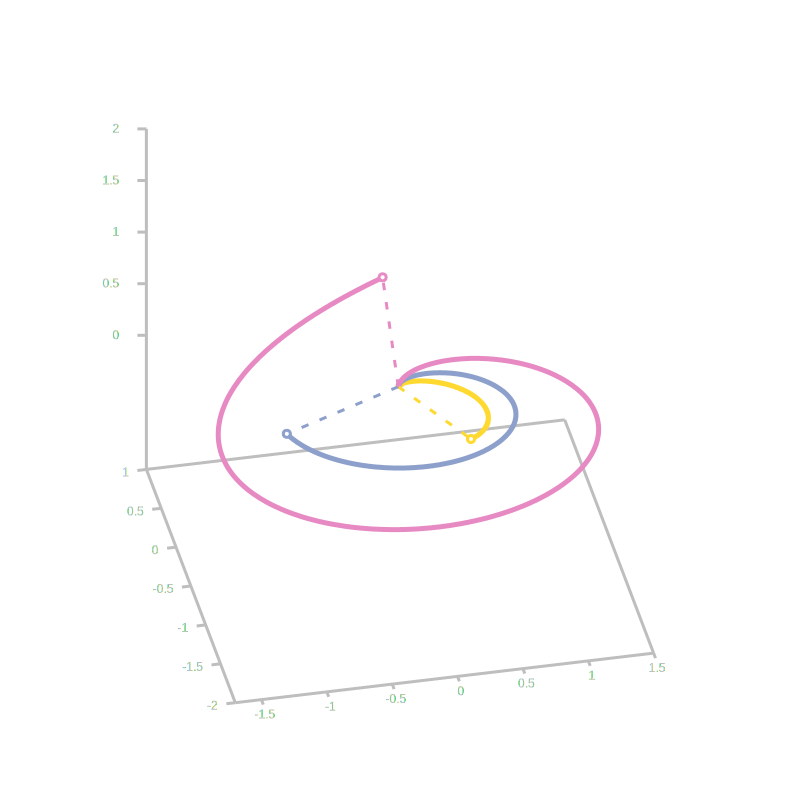

In [5]:
let () =
  let open Gp in
  let display_id = Jupyter_notebook.display "text/html" "" in
  let figure (module P: Plot) = 
      P.ex "load 'set2.pal'";
      P.splots  
      [
          item (A results.(0).x) ~using:("2:3:4") ~style:"l ls 6 lw 5";
          item (A results.(1).x) ~using:("2:3:4") ~style:"l ls 3 lw 5";
          item (A results.(2).x) ~using:("2:3:4") ~style:"l ls 4 lw 5";
          item (A results.(0).target) ~using:("(0):(0):(0):1:2:3") ~style:"vectors ls 6 lw 3 dt 2 nohead";
          item (A results.(1).target) ~using:("(0):(0):(0):1:2:3") ~style:"vectors ls 3 lw 3 dt 2 nohead";
          item (A results.(2).target) ~using:("(0):(0):(0):1:2:3") ~style:"vectors ls 4 lw 3 dt 2 nohead";
          item (A results.(0).target) ~using:("1:2:3") ~style:"p ls 6 pt 7";
          item (A results.(1).target) ~using:("1:2:3") ~style:"p ls 3 pt 7";
          item (A results.(2).target) ~using:("1:2:3") ~style:"p ls 4 pt 7";
          item (A results.(0).target) ~using:("1:2:3") ~style:"p pt 7 lc rgb 'white' ps 0.4";
          item (A results.(1).target) ~using:("1:2:3") ~style:"p pt 7 lc rgb 'white' ps 0.4";
          item (A results.(2).target) ~using:("1:2:3") ~style:"p pt 7 lc rgb 'white' ps 0.4";
      ]
      [ 
          set "border 31 lt rgb 'gray' lw 3"; 
          set "view 55,348";
          zrange (-0.2,2.);
          yrange (-2.,1.);
          xrange (-1.7,1.5)
      ]
       in
  Juplot.draw ~display_id ~size:(800,800) figure

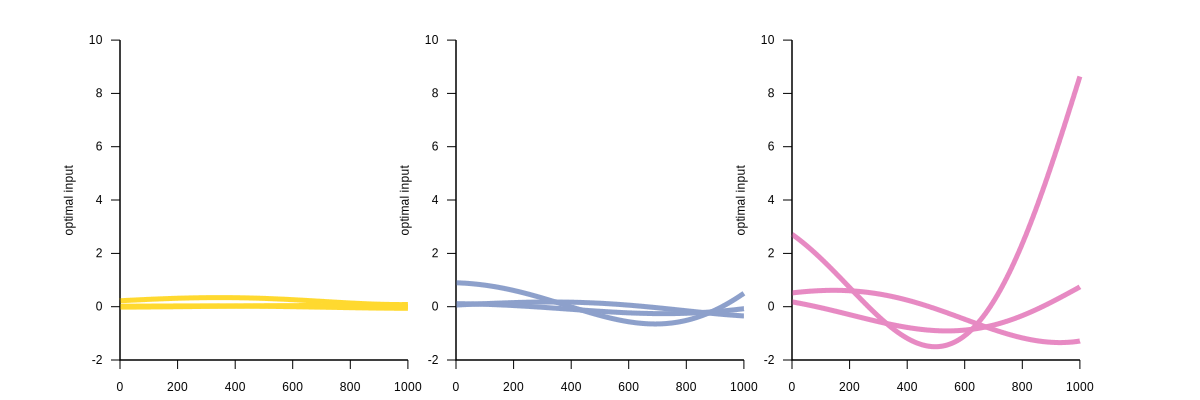

In [6]:
let () =
  let open Gp in
  let display_id = Jupyter_notebook.display "text/html" "" in
  let colors = [| 6; 3; 4 |] in
  let figure (module P: Plot) = 
      P.ex "load 'set2.pal'";
      P.multiplot (1,3) (fun k _ _ -> 
          P.plots 
          List.(init 3 (fun i -> 
              item (A results.(k).u) 
              ~using:(sprintf "0:%i" (succ i))
              ~style:(sprintf "l ls %i lw 5" colors.(k)) 
              ))
      [ 
          yrange (-2.,10.);
          ylabel "optimal input";
          xlabel "time [ms]";
          set "border 3";
      ]
      ) in
  Juplot.draw ~display_id ~size:(1200,400) figure

In [7]:
(* save sample from stationary distribution *)
let samples =
  (* let p = Linalg.D.lyapunov a Mat.(neg (eye n)) in *)
  let u, s, _ = Linalg.D.svd p in
  let ell = Mat.(u * sqrt s) in
  Mat.(ell *@ gaussian n 500) |> Mat.transpose

val samples : Owl.Mat.mat = ...


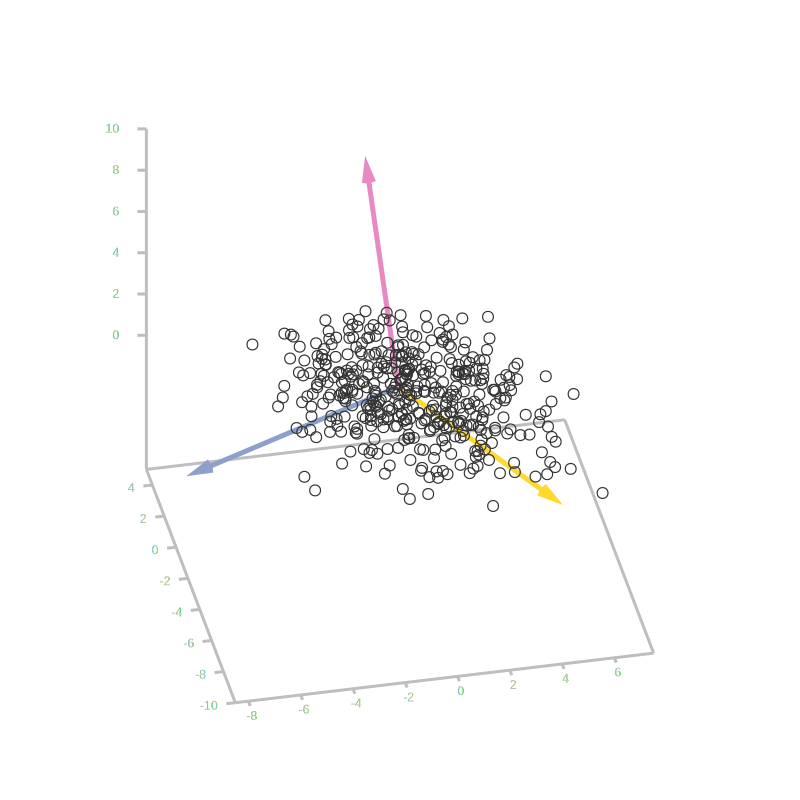

In [8]:
let () =
  let open Gp in
  let display_id = Jupyter_notebook.display "text/html" "" in
  let scale = 15. in
  let d1 = Mat.(scale $* results.(0).target) in
  let d2 = Mat.(scale $* results.(1).target) in
  let d3 = Mat.(scale $* results.(2).target) in
  let figure (module P: Plot) = 
      P.ex "load 'set2.pal'";
      P.splots  
      [
          item (A d1) ~using:("(0):(0):(0):1:2:3") ~style:"vectors ls 6 lw 5 head";
          item (A d2) ~using:("(0):(0):(0):1:2:3") ~style:"vectors ls 3 lw 5 head";
          item (A d3) ~using:("(0):(0):(0):1:2:3") ~style:"vectors ls 4 lw 5 head";
          item (A samples) ~using:("1:2:3") ~style:"p pt 6 ps 1.2 lc rgb '#333333'";
      ]
      [ 
          set "border 31 lt rgb 'gray' lw 3"; 
          set "view 55,348";
          zrange (-1.,10.);
          yrange (-10.,5.);
          xrange (-8.5,7.5)
      ] in
  Juplot.draw ~display_id ~size:(800,800) figure